In [39]:
from SimPEG import Mesh, Utils, mkvc, Maps
import SimPEG.EM.Static.DC as DC
import SimPEG.EM.Static.Utils as StaticUtils
import pylab as plt
import numpy as np
import scipy.sparse as sp
import time
import re
import numpy.matlib as npm
import scipy.interpolate as interpolation
from pymatsolver import PardisoSolver
import os
%pylab 
from scipy.interpolate import griddata

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dtype', 'std', 'plt', 'var', 'griddata']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
# home_dir = "/home/seogi/Projects/em_examples/geophysical_survey/DCR/"
home_dir = "/Users/sgkang/Projects/em_examples/geophysical_survey/DCR/"
dsep = '/'

# Specify survey type
stype = 'dipole-dipole'
# dtype = 'appResistivity'
dtype = 'appConductivity'
# Survey parameters
b = 20 # Tx-Rx seperation
a = 20 # Dipole spacing
n = 15  # Number of Rx per Tx

# Model parameters (background, sphere1, sphere2)
sig = np.r_[1e-2, 1e-1, 1e-3]
eta = 0.1
# Centroid of spheres
loc = np.c_[[-75., 0., -75.], [75., 0., -75.]]
# Radius of spheres
radi = np.r_[50.,50.]

# DOI threshold
cutoff = 0.8
# number of padding cells
padc = 0

# Plotting param
xmin, xmax = -250, 250
ymin, ymax = -150, 150
zmin, zmax = -125, 25
vmin = -2.4771213
vmax = -1.4771213
depth = 200. # Maximum depth to plot
dx_in = 5

#`srvy_end = [(-200.  ,  0.), (200.  ,  0.)]
srvy_end = [(-225.,  0.), (225.,  0.)]
#%% SCRIPT STARTS HERE
nx = int(np.abs(srvy_end[0][0] - srvy_end[1][0]) /dx_in * 1.25)
ny = nx
ny += (ny+1)%2 # Make sure it is odd so the survey is centered

nz = int(np.abs( np.min(loc[2,:]) - np.max(radi) )  /dx_in )

# Create mesh
hxind = [(dx_in,15,-1.3), (dx_in, nx), (dx_in,15,1.3)]
hyind = [(dx_in,15,-1.3), (dx_in, int(ny/3)), (dx_in,15,1.3)]
hzind = [(dx_in,13,-1.3),(dx_in, nz)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCN')

# Set background conductivity
model = np.ones(mesh.nC) * sig[0]
# Create model 
model0 = model.copy()

## BLOCK MODEL
# Create blocs for gradient plot
ind = Utils.ModelBuilder.getIndicesBlock(([-25.,-25.,-75]),([25.,25.,-20]),mesh.gridCC)
model[ind] = sig[1]

ind = Utils.ModelBuilder.getIndicesBlock(([-150.,-10.,-25]),([-130.,10.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
model0[ind] = sig[1]/2.5*(1-eta)
#
ind = Utils.ModelBuilder.getIndicesBlock(([-70.,-10.,-25]),([-50.,10.,0]),mesh.gridCC)
model[ind] = sig[2]
model0[ind] = sig[2]*(1-eta)
#
ind = Utils.ModelBuilder.getIndicesBlock(([110.,-10.,-25]),([130.,10.,0]),mesh.gridCC)
model[ind] = sig[1]/5.
model0[ind] = sig[1]/5.*(1-eta)

ind = Utils.ModelBuilder.getIndicesBlock(([-140.,-100.,-25]),([-120.,-80.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
model0[ind] = sig[1]/2.5*(1-eta)
#
# ind = Utils.ModelBuilder.getIndicesBlock(([-20.,-20.,-25]),([0.,0.,0]),mesh.gridCC)
# model[ind] = sig[1]/2.5
#
ind = Utils.ModelBuilder.getIndicesBlock(([125.,100.,-25]),([145,120.,0]),mesh.gridCC)
model[ind] = sig[1]/5
model0[ind] = sig[1]/5*(1-eta)

ind = Utils.ModelBuilder.getIndicesBlock(([80.,-125.,-25]),([100,-105.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
model0[ind] = sig[1]/2.5*(1-eta)

ind = Utils.ModelBuilder.getIndicesBlock(([-110.,80.,-25]),([-90,100.,0]),mesh.gridCC)
model[ind] = sig[1]/2.5
model0[ind] = sig[1]/2.5*(1-eta)
ind = Utils.ModelBuilder.getIndicesBlock(([-25.,-25.,-75]),([25.,25.,-20]),mesh.gridCC)
model0[ind] = sig[1]*(1-eta)
chg = (model-model0)/model

In [41]:
plt.figure()
axs = plt.subplot(1,1,1)
# dat1 = mesh.plotSlice(np.log10(model), ind=-5, normal='Z', grid=False, pcolorOpts={'alpha':1}, ax =axs)
dat1 = mesh.plotSlice(chg, ind=-5, normal='Z', grid=False, pcolorOpts={'alpha':0.5}, ax =axs)
axs.set_ylim(ymin,ymax)
axs.set_xlim(xmin,xmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [42]:
def plotPoles(survey,stype,axs):
    for ss in range(survey.nSrc):
        tx = np.c_[survey.srcList[ss].loc]

        if stype == 'dipole-dipole':
            axs.scatter(tx[0,0],tx[0,2],c='k',s=25)

        else:
            axs.scatter(tx[0],tx[2],c='k',s=25)

    tx = np.c_[survey.srcList[0].loc]

    if stype == 'dipole-dipole':
        axs.scatter(tx[0,0],tx[0,2],c='r',s=75, marker='v')
        axs.scatter(tx[1,0],tx[1,2],c='b',s=75, marker='v')
    else:
        axs.scatter(tx[0],tx[2],c='r',s=75, marker='v')

In [35]:
# Add z coordinate to all survey... assume flat
nz = mesh.vectorNz
var = np.c_[np.asarray(srvy_end),np.ones(2).T*nz[-1]]

# Snap the endpoints to the grid. Easier to create 2D section.
indx = Utils.closestPoints(mesh, var )
endl = np.c_[mesh.gridCC[indx,0],mesh.gridCC[indx,1],np.ones(2).T*nz[-1]]

survey = StaticUtils.gen_DCIPsurvey(endl, mesh, stype, a, b, n)
#survey = DC.SurveyDC.Survey(srcList)

Tx = StaticUtils.getSrc_locs(survey)

dl_len = np.sqrt( np.sum((endl[0,:] - endl[1,:])**2) )
dl_x = ( Tx[-1][0] - Tx[0][0] ) / dl_len
dl_y = ( Tx[-1][1] - Tx[0][1]  ) / dl_len
azm =  np.arctan(dl_y/dl_x)

problem = DC.Problem3D_CC(mesh, sigmaMap = Maps.IdentityMap(mesh))
problem.Solver = PardisoSolver
problem.pair(survey)
dpred = survey.dpred(model)
dpred0 = survey.dpred(model0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]


In [36]:
datatype = "IP"

if datatype == "DC":
    data = dpred.copy()
    # Inversion parameter
    pct = 0.02 # Percent of abs(obs) value
    flr = 1e-4 # Minimum floor value
    chifact = 100
    ref_mod = [1e-2, 1e-1]
    
elif datatype == "IP":
    data = (dpred0-dpred ) / dpred0 *1e3
    # Inversion parameter
    pct = 0.0 # Percent of abs(obs) value
    flr = 1. # Minimum floor value
    chifact = 100
    ref_mod = [1e-2, 1e-1]
        
std = abs(data)*pct + flr
survey.dobs = data.copy()
survey.std = std.copy()     

#%% Run 2D inversion if pdp or dpdp survey
# Otherwise just plot and apparent susceptibility map

#%% Convert 3D obs to 2D and write to file
problem = DC.Problem3D_CC(mesh, sigmaMap = Maps.IdentityMap(mesh))
survey2D = StaticUtils.convertObs_DC3D_to_2D(survey,np.ones(survey.nSrc),flag = 'Xloc')

#    survey2D = DC.SurveyDC.Survey(srcList2D)
survey2D.pair(problem)

survey2D.dobs = survey.dobs
survey2D.std = survey.std

#    StaticUtils.writeUBC_DCobs(home_dir+'\FWR_3D_2_2D.dat',survey2D,'2D','SURFACE')

#%% Create a 2D mesh along axis of Tx end points and keep z-discretization
dx = np.min( [ np.min(mesh.hx), np.min(mesh.hy) ])
nc = np.ceil(dl_len/dx)+3

padx = dx*np.power(1.4,range(1,15))

# Creating padding cells
h1 = np.r_[padx[::-1], np.ones(nc)*dx , padx]

# Create mesh with 0 coordinate centerer on the ginput points in cell center
x0 = srvy_end[0][0] - np.sum(padx) * np.cos(azm)
y0 = srvy_end[0][1] - np.sum(padx) * np.sin(azm)
mesh2d = Mesh.TensorMesh([h1, mesh.hz], x0=(x0,mesh.x0[2]))

# Create array of points for interpolating from 3D to 2D mesh
xx = x0 + (np.cumsum(mesh2d.hx) - mesh2d.hx/2) * np.cos(azm)
yy = y0 + (np.cumsum(mesh2d.hx) - mesh2d.hx/2) * np.sin(azm)
zz = mesh2d.vectorCCy

[XX,ZZ] = np.meshgrid(xx,zz)
[YY,ZZ] = np.meshgrid(yy,zz)

xyz2d = np.c_[mkvc(XX),mkvc(YY),mkvc(ZZ)]

if datatype == "DC":
    vmin = -2.4771213
    vmax = -1.4771213    
    Model = model.copy()
elif datatype == "IP":
    vmin = 0
    vmax = 100
    Model = 10**(chg.copy()*1e3)

F = interpolation.NearestNDInterpolator(mesh.gridCC,Model)
m2D = np.reshape(F(xyz2d),[mesh2d.nCx,mesh2d.nCy]).T


#%% Plot a section through the spheres
fig = plt.figure(figsize=(8,6))

axs = plt.subplot(2,1,1, aspect='equal')

pos =  axs.get_position()
axs.set_position([pos.x0 , pos.y0 + 0.05 ,  pos.width, pos.height])

im1 = axs.pcolormesh(mesh2d.vectorCCx,mesh2d.vectorCCy,np.log10(m2D),clim=(vmin,vmax), vmin=vmin, vmax =vmax)

plotPoles(survey2D,stype,axs)

axs.set_ylim(zmin,zmax)
axs.set_xlim(xmin,xmax)
plt.gca().set_aspect('equal', adjustable='box')
x = np.linspace(xmin,xmax, 5)
axs.set_xticks(map(int, x))
axs.set_xticklabels(map(str, map(int, x)),size=12)
z = np.linspace(zmin,zmax, 3)
axs.set_yticks(map(int, z))
axs.set_ylabel('Depth (m)')
axs.set_yticklabels(map(str, map(int, z)),size=12)
axs.axes.get_xaxis().set_visible(False)
axs = plt.subplot(2,1,2, aspect='equal')

pos =  axs.get_position()
axs.set_position([pos.x0 , pos.y0 + 0.05 ,  pos.width, pos.height])

# SEOGI: We need to be able to output the midz location for replacing
# zlabel to n-spacing, or do it directly in the ploting function
if datatype == "DC":
    ph, ax, cbar, LEG = StaticUtils.plot_pseudoSection(survey2D,axs,surveyType=stype, dataType=dtype, clim = [vmin,vmax], scale='log')
    plt.gca().set_aspect('equal', adjustable='box')
    axs.set_ylim(zmin,zmax)
    axs.set_xlim(xmin,xmax)
    plt.gca().set_aspect('equal', adjustable='box')
    x = np.linspace(xmin,xmax, 5)
    axs.set_xticks(map(int, x))
    axs.set_xticklabels(map(str, map(int, x)),size=12)
    cbar.set_ticklabels([300, 100, 30])
    cbar.set_label("App. Resistivity (Ohm-m)")
elif datatype == "IP":
    ph, ax, cbar, LEG = StaticUtils.plot_pseudoSection(survey2D,axs,surveyType=stype, dataType='volt')
    plt.gca().set_aspect('equal', adjustable='box')
#     axs.set_ylim(zmin,zmax)
    axs.set_xlim(xmin,xmax)
    plt.gca().set_aspect('equal', adjustable='box')
    x = np.linspace(xmin,xmax, 5)
    axs.set_xticks(map(int, x))
    axs.set_xticklabels(map(str, map(int, x)),size=12)
    cbar.set_label("App. Chargeability (mV/V)")

axs.set_yticks((-5*np.r_[1, 5, 10, 15]-5.).tolist())
axs.set_yticklabels(map(str, [1, 5, 10, 15]))
axs.set_ylabel("n-spacing")
    
plt.show()
plt.plot((xmin,xmax),(0,0),color='k',lw=1)

plotPoles(survey2D,stype,axs)    

In [12]:
if datatype == "DC":
    vmin = -2.4771213
    vmax = -1.4771213    
    Model = model.copy()
    iptype = 0
elif datatype == "IP":
    vmin = 0
    vmax = 100
    Model = 10**(chg.copy())
    iptype = 1
    niter = 30
    
jj = 0
DOI = False
INVERT = True

pos =  axs.get_position()
cbarax = fig.add_axes([pos.x0 + 0.2 , pos.y0 - 0.025,  pos.width*0.5, pos.height*0.05])  ## the parameters are the specified position you set
cbar = fig.colorbar(ph,cax=cbarax, orientation="horizontal", ax = axs, ticks=np.linspace(vmin,vmax, 3), format="$10^{%.1f}$")
cbar.set_label('log [App. Cond.]')

# %% Run two inversions with different reference models and compute a DOI

#plt.figure()
#==============================================================================
# fig = plt.figure(figsize=(7,7))
#==============================================================================
# Create dcin2d inversion files and run


os.chdir(home_dir)
inv_dir = home_dir + 'Inv2D'
if not os.path.exists(inv_dir):
    os.makedirs(inv_dir)
if datatype == "DC":
    mshfile2d = 'Mesh_2D.msh'
    modfile2d = 'Model_2D.con'
    obsfile2d = 'FWR_3D_2_2D.dat'
    inp_file = 'dcinv2d.inp'
elif datatype == "IP":
    mshfile2d = 'Mesh_2D.msh'
    modfile2d = 'CHG_2D.con'
    obsfile2d = 'IPFWR_3D_2_2D.dat'
    inp_file = 'ipinv2d.inp'
    condfile2d = 'dcinv2d.con'

# Export 2D mesh
fid = open(inv_dir + dsep + mshfile2d,'w')
fid.write('%i\n'% mesh2d.nCx)
fid.write('%f %f 1\n'% (mesh2d.vectorNx[0],mesh2d.vectorNx[1]))
np.savetxt(fid, np.c_[mesh2d.vectorNx[2:],np.ones(mesh2d.nCx-1)], fmt='\t %e %i',delimiter=' ',newline='\n')
fid.write('\n')
fid.write('%i\n'% mesh2d.nCy)
fid.write('%f %f 1\n'%( 0,mesh2d.hy[-1]))
np.savetxt(fid, np.c_[np.cumsum(mesh2d.hy[-2::-1])+mesh2d.hy[-1],np.ones(mesh2d.nCy-1)], fmt='\t %e %i',delimiter=' ',newline='\n')
fid.close()

# Export 2D model
fid = open(inv_dir + dsep + modfile2d,'w')
fid.write('%i %i\n'% (mesh2d.nCx,mesh2d.nCy))
np.savetxt(fid, mkvc(m2D[::-1,:].T), fmt='%e',delimiter=' ',newline='\n')
fid.close()

# Export data file
StaticUtils.writeUBC_DCobs(inv_dir+dsep+obsfile2d,survey2D,'2D','SIMPLE', iptype=0)

if datatype == "DC":
    # Write input file
    fid = open(inv_dir + dsep + inp_file,'w')
    fid.write('OBS LOC_X %s \n'% obsfile2d)
    fid.write('MESH FILE %s \n'% mshfile2d)
    fid.write('CHIFACT 1 %f\n'% chifact)
    fid.write('TOPO DEFAULT \n')
    fid.write('INIT_MOD VALUE %e\n'% (ref_mod[jj]))
    fid.write('REF_MOD VALUE %e\n'% (ref_mod[jj]))
    fid.write('ALPHA VALUE %f %f %f\n'% (1./a**2., 1, 1))
    fid.write('WEIGHT DEFAULT\n')
    fid.write('STORE_ALL_MODELS FALSE\n')
    fid.write('INVMODE SVD\n')
    fid.write('USE_MREF FALSE\n')
    fid.close()
elif datatype == "IP":
    fid = open(inv_dir + dsep + inp_file,'w')
    fid.write('MESH FILE %s \n'% mshfile2d)
    fid.write('OBS LOC_X %s \n'% obsfile2d)    
    fid.write('NITER %s \n'% niter)
    fid.write('CHIFACT 1 %f\n'% chifact)
    fid.write('TOPO DEFAULT \n')
    fid.write('INIT_MOD VALUE %e\n'% (ref_mod[jj]))
    fid.write('REF_MOD VALUE %e\n'% (ref_mod[jj]))
    fid.write('COND FILE %s \n' % condfile2d)    
    fid.write('ALPHA VALUE %f %f %f\n'% (1./a**2., 1, 1))
    fid.write('WEIGHT DEFAULT\n')
    fid.write('STORE_ALL_MODELS FALSE\n')
    fid.write('INVMODE SVD\n')
    fid.write('USE_MREF FALSE\n')
    fid.close()
    
os.chdir(inv_dir)
# os.system('dcinv2d ' + inp_file)

In [97]:
# out = hist((abs(survey2D.dobs)), bins=100)

In [98]:
#Load model

invmod =  StaticUtils.readUBC_DC2DModel('dcinv_100/dcinv2d.con')
invmod1 =  StaticUtils.readUBC_DC2DModel('dcinv_10/dcinv2d.con')
invmodIP =  StaticUtils.readUBC_DC2DModel('ipinv/ipinv2d.chg')

dpre = StaticUtils.readUBC_DC2Dpre('dcinv_100/dcinv2d.pre')
DCpre = dpre['DCsurvey']
DCtemp = survey2D
DCtemp.dobs = DCpre.dobs
#%% Compute DOI
DOI = np.abs(invmod - invmod1) / np.abs(ref_mod[0] - ref_mod[1])
# Normalize between [0 1]
DOI = DOI - np.min(DOI)
DOI = (1.- DOI/np.max(DOI))

In [38]:
#%% Plot a section through the spheres
fig = plt.figure(figsize=(8,6))

axs = plt.subplot(2,1,1, aspect='equal')

pos =  axs.get_position()
axs.set_position([pos.x0 , pos.y0 + 0.05 ,  pos.width, pos.height])

im1 = axs.pcolormesh(mesh2d.vectorCCx,mesh2d.vectorCCy,np.log10(m2D),clim=(vmin,vmax), vmin=vmin, vmax =vmax, cmap="jet")

plotPoles(survey2D,stype,axs)

axs.set_ylim(zmin,zmax)
axs.set_xlim(xmin,xmax)
plt.gca().set_aspect('equal', adjustable='box')
x = np.linspace(xmin,xmax, 5)
axs.set_xticks(map(int, x))
axs.set_xticklabels(map(str, map(int, x)),size=12)
z = np.linspace(zmin,zmax, 3)
axs.set_yticks(map(int, z))
axs.set_ylabel('Depth (m)')
axs.set_yticklabels(map(str, map(int, z)),size=12)
axs.axes.get_xaxis().set_visible(False)
axs = plt.subplot(2,1,2, aspect='equal')

pos =  axs.get_position()
axs.set_position([pos.x0 , pos.y0 + 0.05 ,  pos.width, pos.height])

axs = plt.subplot(2,1,2, aspect='equal')
pos =  axs.get_position()
axs.set_position([pos.x0 , pos.y0 + 0.05 ,  pos.width, pos.height])

if datatype == "DC":
    minv = np.reshape(np.log10(invmod),(mesh2d.nCy,mesh2d.nCx))
    label = 'Resistivity ($\Omega \cdot m$)'
    xtick = [str(int(10**-vmin)), str(int(np.round(10**(-(vmin+vmax)/2)/10)*10)), str(int(10**-vmax))]
elif datatype == "IP":
    minv = np.reshape(invmodIP,(mesh2d.nCy,mesh2d.nCx))
    label = 'Chargeability (mV/V)'
    xtick = map(str, np.r_[0, 50, 100])
    
ph = axs.pcolormesh(mesh2d.vectorNx,mesh2d.vectorNy,minv,vmin = vmin, vmax = vmax,edgecolor="none", cmap="jet")
axs.set_ylim(zmin,zmax)
axs.set_xlim(xmin,xmax)
plt.gca().set_aspect('equal', adjustable='box')
x = np.linspace(xmin,xmax, 5)
axs.set_xticks(map(int, x))
axs.set_xticklabels(map(str, map(int, x)),size=12)
z = np.linspace(zmin,zmax, 4)
axs.set_yticks(map(int, z))
axs.set_yticklabels(map(str, map(int, z)),size=12)
axs.set_ylabel('Depth (m)')

cbarax = fig.add_axes([pos.x0 + 0.2 , pos.y0 - 0.04,  pos.width*0.5, pos.height*0.05])  ## the parameters are the specified position you set
cbar = fig.colorbar(ph,cax=cbarax, orientation="horizontal", ax = axs, ticks=np.linspace(vmin,vmax, 3))
cbar.ax.set_xticklabels(xtick)
cbar.set_label(label)

NameError: name 'invmodIP' is not defined

In [100]:
rgba_plt = ph.get_facecolor()
rgba_plt[:,3] = mkvc(DOI.T)**2.
ph.set_facecolor(rgba_plt)
plotPoles(survey2D,stype,axs)
plt.show()

In [8]:
from SimPEG import EM, np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
freq = np.logspace(2, 10, 71)
data = EM.Analytics.hzAnalyticDipoleF(8., freq, 1e-2)

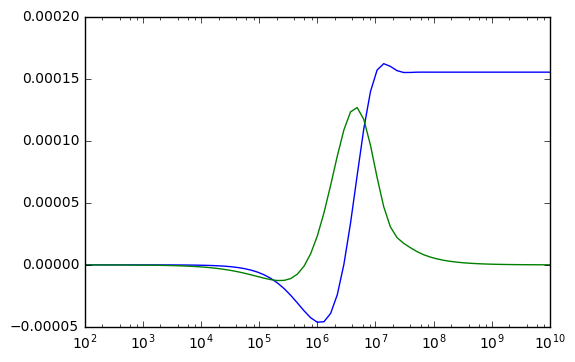

In [27]:
plt.semilogx(freq, data.real)
plt.semilogx(freq, data.imag)